<a href="https://colab.research.google.com/github/yukiya06/Game_DataAnalysis/blob/main/Game_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# matplotlib 세팅
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
pip install pingouin

In [46]:
# Python modules setting
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
import pingouin as pg

## [1] 데이터 전처리

## 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/vgames2.csv', index_col='Unnamed: 0')
df.head(1)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0


##데이터 구조확인 (파악용)

In [3]:
df.shape # 데이터 크기: (16598, 9)
df.info() # 데이터 종류: year만 float, 나머지 obj → 수치변환 필요
df.isnull().sum() # 데이터Null값 : Year  271개 / Genre 50개 / Publisher 58개

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

## 연속형데이터(수치) 단위 통일


*   Sales 단위를 'M'으로 통일하고, 실수화(float) 진행



In [4]:
df1 = df.copy() # 실수하면 여기로 돌아온다, 변경할 DataFrame

In [5]:
# df1['NA_Sales'].unique()로 확인하여 데이터 양식 파악
# K(10**3)나 M(10**6)이 섞여 있음

def to_float(x) :
  if 'K' in x :
    if float(x.replace('K','')) > 0 :
      return round(float(x.replace('K','')) / 1000, 2)
    else :
      return 0.0
  if 'M' in x :
    return float(x.replace('M',''))
  else :
    return float(x)

In [6]:
df1['NA_Sales'] = df1['NA_Sales'].apply(to_float)
df1['EU_Sales'] = df1['EU_Sales'].apply(to_float)
df1['JP_Sales'] = df1['JP_Sales'].apply(to_float)
df1['Other_Sales'] = df1['Other_Sales'].apply(to_float)

In [7]:
# Sales sum columns 추가
df1['Sales_sum']=df1['NA_Sales']+df1['EU_Sales']+df1['JP_Sales']+df1['Other_Sales']

In [ ]:
# 중간점검
#df1.dtypes # 변경여부 확인
#df1.describe() # Sales에서 mean/median 차이큼, min/max 차이큼

# 연도표시 단위 통일 

*   4자리수(ex: 2020)로 변경,  정수화(int) 진행



In [8]:
# 연도표시에 2자리수, 4자리수 혼용 → 4자리수로 변경
def change_year(x):
  if x < 50 :
    x += 2000
  elif x > 50 and x < 100:
    x += 1900
  return x

# null값 없애고 나서 변환확인
# df_f['Year'].unique()

In [9]:
df1['Year'] = df1['Year'].apply(change_year)

## 결측치 확인


*   결측치 행 갯수로 비율 확인
*   Sales sum 비율 확인



In [10]:
df.isnull().sum() / len(df)
# 결측시 수량 비율이 적으므로 행 삭제도 고려 가능
# Year는 sales양으로 비율을 계산해도 영향이 적은지 확인후 행 삭제 고려

Name           0.000000
Platform       0.000000
Year           0.016327
Genre          0.003012
Publisher      0.003494
NA_Sales       0.000000
EU_Sales       0.000000
JP_Sales       0.000000
Other_Sales    0.000000
dtype: float64

In [11]:
##null값이 있는 데이터추출, 데이터 확인
null_data = df1[df1.isnull().any(axis=1)] 

In [12]:
## Publisher 결측치 처리
null_data = null_data.replace({'Publisher': np.nan}, {'Publisher': 'Unknown'}) 

## Genre 결측치 처리
null_data = null_data.replace({'Genre': np.nan}, {'Genre': 'Unknown'}) 

## Year 결측치 처리 
null_data = null_data.replace({'Year': np.nan}, {'Year': 0.0})

In [13]:
#추후 분석에 year와 genre가 많이 사용되는데 계속 미지수로 가져가기 어려움
#sales로 분석해도 5%미만 수치로 삭제하고 간다.

nc1 = null_data['Genre'] == 'Unknown'
df_nc1 = null_data.loc[nc1]
df_nc1['Sales_sum'].sum() / df1['Sales_sum'].sum()

0.005849133845903643

In [14]:
nc2 = null_data['Year'] == 0
df_nc2 = null_data.loc[nc2]
df_nc2['Sales_sum'].sum() / df1['Sales_sum'].sum()

0.011214858931004894

In [15]:
## Publisher 결측치 처리
#Publisher에는 Unknown이랑 NaN 존재
#Unknown도 빈도가 높으므로 이것으로 통일

cond1 = df1['Publisher'] == 'Unknown'  
df1 = df1.replace({'Publisher': np.nan}, {'Publisher': 'Unknown'}) 

In [16]:
## Year, Genre에 있는 결측치는 삭제
df_f = df1.loc[df1[['Year','Genre']].dropna(axis=0).index]
df_f = df_f.astype({'Year':'int'}) # 연도는 숫자 보기좋게 변경
df_f.shape

(16277, 10)

In [ ]:
#df_f.isnull().sum() # 처리 확인

## 게임 도메인 파악
# 1) Genre

In [17]:
print(len(df_f['Genre'].unique()))
print(df_f['Genre'].unique())

12
['Action' 'Adventure' 'Misc' 'Platform' 'Sports' 'Simulation' 'Racing'
 'Role-Playing' 'Puzzle' 'Strategy' 'Fighting' 'Shooter']


##2) Platform

In [18]:
print(len(df_f['Platform'].unique()))
print(df_f['Platform'].unique())

31
['DS' 'Wii' 'PSP' 'PS3' 'PC' 'PS' 'GBA' 'PS4' 'PS2' 'XB' 'X360' 'GC' '3DS'
 '2600' 'SAT' 'GB' 'NES' 'DC' 'N64' 'XOne' 'SNES' 'WiiU' 'PSV' 'GEN' 'SCD'
 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']


Platform 변수가 많으므로, 모회사 기준으로 묶어서 새로운 변수 생성 (외부데이터 사용)

In [19]:
# platform 회사 구분인자 추가
company_index = {'NES':'Nintendo', 'SNES':'Nintendo', 'GB':'Nintendo', 'N64':'Nintendo', 'GBA':'Nintendo', 'GC':'Nintendo',
                 'DS':'Nintendo', '3DS':'Nintendo', 'Wii':'Nintendo', 'WiiU':'Nintendo',
                 'PSP':'Sony', 'PSV':'Sony', 'PS':'Sony', 'PS2':'Sony', 'PS3':'Sony','PS4':'Sony',
                 'XB':'Microsoft', 'X360':'Microsoft', 'XOne':'Microsoft',
                 '2600':'Atari', 'GEN':'Sega', 'SCD':'Sega','SAT':'Sega','DC':'Sega','GG':'Sega',
                 'WS':'Bandai','NG':'SNK','TG16':'Nec', 'PCFX':'Nec', '3DO':'3DO', 'PC':'PC'
                 }

df_f['Company'] = df_f['Platform'].map(company_index)

게임기의 주요 특징인 가정용/휴대용을 구분하는 변수를 추가

In [20]:
# 게임기 대구분 (가정용/ 휴대용)
usage_index = {'GB':'portable', 'GBA':'portable', 'DS':'portable', '3DS':'portable', 'PSP':'portable', 'PSV':'portable',
               'WS':'portable', 'GG':'portable', 'NES':'family', 'SNES':'family', 'N64':'family', 'GC':'family',
               'Wii':'family','WiiU':'family','PS':'family','PS2':'family','PS3':'family','PS4':'family','2600':'family',
               'XB':'family','X360':'family','XOne':'family','GEN':'family','SCD':'family','SAT':'family',
               'DC':'family', 'NG':'family', 'TG16':'family', 'PCFX':'family', '3DO':'family', 'PC':'family'}

df_f['Usage'] = df_f['Platform'].map(usage_index)

#3) 연도


*   1980년-2017년까지 매년 데이터 수집
*   2020년 데이터 존재

In [21]:
df_f['Year'].unique()

array([2008, 2009, 2010, 2005, 2011, 2007, 2001, 2003, 2006, 2014, 2015,
       2002, 1997, 2013, 1996, 2004, 2000, 1984, 1998, 2016, 1985, 1999,
       1995, 1993, 2012, 1987, 1982, 1994, 1990, 1992, 1991, 1983, 1988,
       1981, 1989, 1986, 2017, 1980, 2020])

#4) 게임타이틀 (중복데이터 확인)

In [22]:
# 동일이름의 게임이 중복된 데이터가 있는지 확인
# 중복된 모든 행에 중복 flag(True) 하여 추출

dup = df_f.duplicated(['Name'], keep=False) 
df_dup = pd.concat([df_f, dup], axis=1)

df_duponly = df_dup.loc[dup, :]
df_duponly.head(1)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_sum,Company,Usage,0
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.0,0.0,0.0,0.04,Nintendo,portable,True


In [23]:
# 수량이나, sales합계로 보나 여러 플랫폼으로 발매한 게임이 절반
df_duponly['Sales_sum'].sum() / df_f['Sales_sum'].sum()

0.5234130294133421

In [24]:
len(df_duponly) / len(df_f)

0.4705412545309332

In [ ]:
# 같은제목, 다른 플렛폼으로 발행
# 연도로 검색
#f1 = df_duponly['Year'] ==2001
#df_duponly.loc[f1]

In [ ]:
# 같은제목, 다른 플렛폼으로 발행
# 이름으로 검색
#f2 = df_duponly['Name'] == 'Final Fantasy V' 
#df_duponly.loc[f2]

In [26]:
# 같은제목, 다른 플렛폼으로 발행
# 이름으로 검색
com_sales = pd.pivot_table(df_duponly,index='Company', columns='Year', values='Sales_sum', aggfunc=np.sum, margins=True)
com_sales = com_sales.fillna(0)

##[2] 탐색적 데이터분석 (연관관계 파악) 

In [25]:
# 전체 연도별 매출
dup_sales = pd.pivot_table(df_f, index='Name', columns='Year', values='Sales_sum', aggfunc=np.sum, margins=True)
dup_sales.fillna(0, inplace=True)
dup_sales.tail(1)

Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2010,2011,2012,2013,2014,2015,2016,2017,2020,All
Name,,,,,,,,,,,,,,,,,,,,,
All,10.88,35.68,28.88,16.8,50.35,53.95,37.08,21.7,47.21,73.45,...,591.31,515.04,362.11,353.63,337.1,261.83,70.87,0.05,0.29,8763.71


In [26]:
# 여러 플랫폼 출시된 게임의 연도별 매출
dup_sales2 = pd.pivot_table(df_duponly, index='Name', columns='Year', values='Sales_sum', aggfunc=np.sum, margins=True)
dup_sales2.fillna(0, inplace=True)
dup_sales2.tail(1)

Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,All
Name,,,,,,,,,,,,,,,,,,,,,
All,8.89,5.94,12.79,7.71,8.49,41.68,4.58,1.3,28.95,47.16,...,371.47,351.44,341.84,245.11,277.36,272.78,199.29,53.0,0.04,4587.04


In [27]:
# 장르별 출시된 게임 종류 (중복제거, count)
game_n = df_f.drop_duplicates('Name')

In [28]:
game_n.shape

(11330, 12)

In [29]:
# 장르별 총매출, 평균매출
genre_index = game_n['Genre'].value_counts().sort_values(ascending=False)
genre_sum = df_f.groupby('Genre')['Sales_sum'].sum()

# x축에 맞춰서 df 만들어서 진행
genre_reorder = pd.DataFrame({'Genre': ['Action', 'Sports', 'Misc', 
                                       'Role-Playing', 'Adventure', 'Shooter',
                                       'Racing', 'Simulation', 'Fighting', 
                                       'Platform', 'Strategy', 'Puzzle'], 
                             'Sales_sum' : [1713.02, 1305.34,  787.41,
                                            901.52, 234.22, 1024.75,
                                            722.56, 389.46, 443.54,
                                            828.01, 173.14, 240.74]})

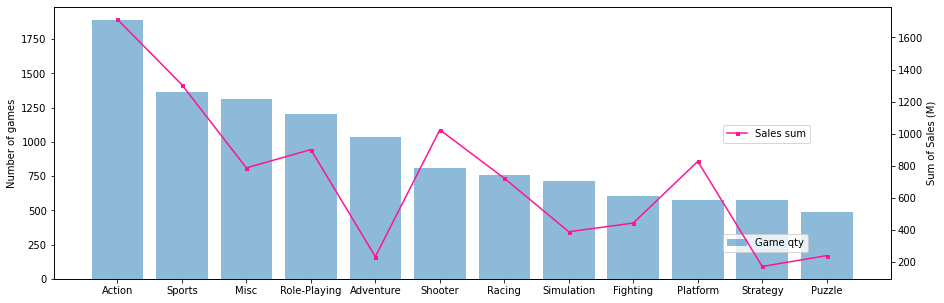

In [30]:
plt.rcParams['figure.figsize'] = (15, 5)

fig, ax1 = plt.subplots() #이중축 그래프 그리기
ax2 = ax1.twinx()

ax1.bar(game_n['Genre'].value_counts().index, game_n['Genre'].value_counts(), color='C0', alpha=0.5, label='Game qty')
ax2.plot(genre_reorder['Genre'], genre_reorder['Sales_sum'], '-s', color='deeppink', markersize=3, label='Sales sum')

ax1.set_ylabel('Number of games')
ax2.set_ylabel('Sum of Sales (M)')

ax1.legend(loc=(0.8,0.1))
ax2.legend(loc=(0.8,0.5))

plt.show()

# 장르별 게임 판매동향



*   **Action**이 발매된 게임 종류도 가장 많고, 총 판매량도 가장 많다.
*   **Shooter**와 **Platform**은 상대적으로 발매된 게임 종류에 비해 총 판매량이 높은편이다.
*   **Adventrue**는 상대적으로 발매된 게임 종류에 비해 총 판매량이 낮은편이다.

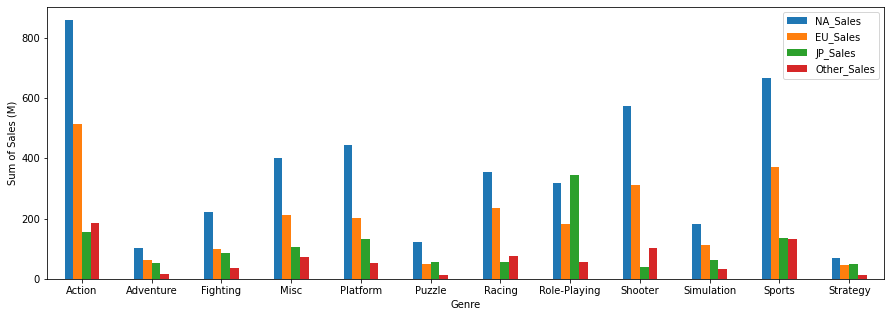

In [31]:
df_f.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().plot.bar(figsize=(15,5))
plt.xticks(rotation=0)
plt.ylabel('Sum of Sales (M)');

대부분 장르가 **북미**지역에서 판매가 가장 많지만, **Role-Playing**이 **일본**판매량이 높은 것과 같이 지역에 따라 다른 판매동향이 보이기도 한다.

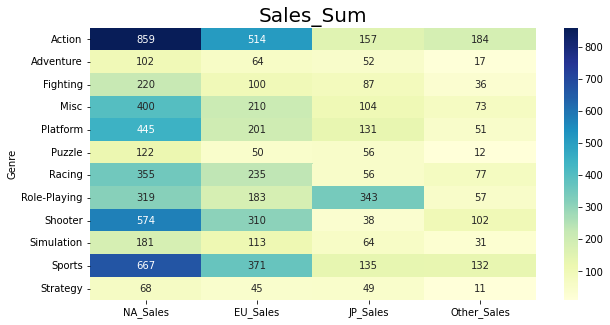

In [32]:
# 히트맵 그래프 : 두개의 범주형변수(장르/국가)에 대한 매출을 시각화

plt.figure(figsize=(10,5))
plt.title('Sales_Sum', fontsize=20)
region= df_f[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
sns.heatmap(region.groupby('Genre').sum(),annot=True, fmt='.0f', cmap='YlGnBu');

국가별 장르에 따른 매출현황을 보면, 


*   북미 : 판매량은 Action, Sports, Shooter이 높지만 Shooter와 Platform의 판매량 차이가 더 유의미하다.
(**Shooter**:  Duck Hunt, Call of Duty / **Platform**:  Super Mario)

*   유럽 : 북미와 유사한 경향으로, Action, Sports, Shooter에서 판매량이 높다. Shooter와 Racing의 판매량이 유의미하다.
(**Racing**:  Mario Kart, Gran Turismo)

*   일본 : 특이하게 **Role-Playing**장르 매출이 높다.
(**Role-Playing**:  Pokemon, Final Fantasy)

*   그외 : 북미,유럽과 비슷한 판매경향을 보이지만 매출양이 적다.

## 지역별 판매량 통계적 검증

* ANOVA를 위한 정규성, 등분산성 검정
* One-way(독립변수1개) ANOVA(분산분석)  
    * 종속변수 (연속형): 매출  
    * 독립변수 (범주형): 장르 (매출top 5)   

1) 북미

In [33]:
# 정규성 검정(Kolmogorov-Smirnov test, 표본 2000개 이상)
# 귀무가설: 정규분포를 따른다
# pvalue < 0.05, 귀무가설을 기각하지 않는다

stats.kstest(df_f['NA_Sales'], 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

In [34]:
df_f[['NA_Sales','Genre']].groupby('Genre').sum().sort_values(by='NA_Sales',ascending=False).head(5)

,NA_Sales
Genre,
Action,858.78
Sports,667.26
Shooter,574.48
Platform,445.38
Misc,400.29


In [55]:
# 등분산성 검정 (bartlett, Levene test)
# 귀무가설: 분산이 같다
# pvalue < 0.05로 분산이 유의미하게 다르다

NA_genre = ['Action', 'Sports', 'Shooter', 'Platform', 'Misc']

d_0 = df_f.loc[df_f['Genre']==NA_genre[0], 'NA_Sales']
d_1 = df_f.loc[df_f['Genre']==NA_genre[1], 'NA_Sales']
d_2 = df_f.loc[df_f['Genre']==NA_genre[2], 'NA_Sales']
d_3 = df_f.loc[df_f['Genre']==NA_genre[3], 'NA_Sales']
d_4 = df_f.loc[df_f['Genre']==NA_genre[4], 'NA_Sales']

In [56]:
stats.bartlett(d_0, d_1, d_2, d_3, d_4)

BartlettResult(statistic=2255.6879901920665, pvalue=0.0)

In [57]:
stats.levene(d_0, d_1, d_2, d_3, d_4, center = 'median')

LeveneResult(statistic=18.329060679313457, pvalue=5.175484900592755e-15)

In [58]:
anova_df = df_f[df_f['Genre'].isin(['Action', 'Sports', 'Shooter', 'Platform', 'Misc'])]

In [59]:
# 등분산이 아닌 경우에 사용하는 ANOVA: Welch test (Brown-Forsythe test)
# ANOVA 귀무가설: 5집단의 평균이 같다
# pvalue < 0.05로 평균이 유의미하게 다르다

pg.welch_anova(dv = 'NA_Sales', between = 'Genre', data = anova_df)

,Source,ddof1,ddof2,F,p-unc,np2
0,Genre,4,3139.270366,13.622099,5.166887e-11,0.009161


In [60]:
# 등분산이 아닌 경우 사후분석:  Games-Howell (Tamhane' T2, Dunnett's T3,Dunnett's C)
# p < 0.05 : 집단 간 평균 차이가 있다.
# Action과 Platform, Shooter는 유의미 하게 다르다
# Misc과 Platform, Shooter는 유의미 하게 다르다
# Sports와 Platform, Shooter는 유의미 하게 다르다

pg.pairwise_gameshowell(dv = 'NA_Sales', between = 'Genre', data = anova_df)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Action,Misc,0.264892,0.234774,0.030118,0.019574,1.538677,2936.832154,5.372602e-01,0.046024
1,Action,Platform,0.264892,0.509588,-0.244696,0.052101,-4.696529,941.075654,2.990862e-05,-0.178967
2,Action,Shooter,0.264892,0.448813,-0.183920,0.035347,-5.203238,1508.106062,2.213420e-06,-0.171734
3,Action,Sports,0.264892,0.290239,-0.025347,0.024042,-1.054309,3265.124120,8.297835e-01,-0.028743
4,Misc,Platform,0.234774,0.509588,-0.274814,0.053820,-5.106156,1065.574506,3.861526e-06,-0.212361
5,Misc,Shooter,0.234774,0.448813,-0.214038,0.037835,-5.657176,1899.317001,1.768105e-07,-0.209168
6,Misc,Sports,0.234774,0.290239,-0.055465,0.027569,-2.011879,3954.870762,2.603433e-01,-0.064289
7,Platform,Shooter,0.509588,0.448813,0.060776,0.061342,0.990759,1598.286001,8.595852e-01,0.043459
8,Platform,Sports,0.509588,0.290239,0.219349,0.055601,3.945057,1205.748242,8.021156e-04,0.156733
9,Shooter,Sports,0.448813,0.290239,0.158573,0.040328,3.932106,2338.178578,8.238570e-04,0.137101


* *Shooter*와 *Platform*의 경우는 pvalue가 매우 작으며, 다른장르의 평균판매량과 유의미한 차이를 보인다.

2) 유럽

In [61]:
# 정규성 검정(Kolmogorov-Smirnov test)
# 귀무가설: 정규분포를 따른다
# pvalue < 0.05, 귀무가설을 기각하지 않는다

stats.kstest(df_f['EU_Sales'], 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

In [62]:
df_f[['EU_Sales','Genre']].groupby('Genre').sum().sort_values(by='EU_Sales',ascending=False).head(5)

,EU_Sales
Genre,
Action,513.64
Sports,370.97
Shooter,310.23
Racing,235.03
Misc,210.20


In [63]:
# 등분산성 검정 (bartlett, Levene test)
# 귀무가설: 분산이 같다
# pvalue < 0.05로 분산이 유의미하게 다르다

EU_genre = ['Action', 'Sports', 'Shooter', 'Racing', 'Misc']

d_0 = df_f.loc[df_f['Genre']==EU_genre[0], 'EU_Sales']
d_1 = df_f.loc[df_f['Genre']==EU_genre[1], 'EU_Sales']
d_2 = df_f.loc[df_f['Genre']==EU_genre[2], 'EU_Sales']
d_3 = df_f.loc[df_f['Genre']==EU_genre[3], 'EU_Sales']
d_4 = df_f.loc[df_f['Genre']==EU_genre[4], 'EU_Sales']

In [64]:
stats.bartlett(d_0, d_1, d_2, d_3, d_4)

BartlettResult(statistic=1331.6879500328955, pvalue=4.4839428996290745e-287)

In [65]:
stats.levene(d_0, d_1, d_2, d_3, d_4, center = 'median')

LeveneResult(statistic=7.087984132065427, pvalue=1.0773948455926297e-05)

In [66]:
anova_df = df_f[df_f['Genre'].isin(['Action', 'Sports', 'Shooter', 'Racing', 'Misc'])]

In [67]:
# 등분산이 아닌 경우에 사용하는 ANOVA: Welch test (Brown-Forsythe test)
# ANOVA 귀무가설: 5집단의 평균이 같다
# pvalue < 0.05로 평균이 유의미하게 다르다

pg.welch_anova(dv = 'EU_Sales', between = 'Genre', data = anova_df)

,Source,ddof1,ddof2,F,p-unc,np2
0,Genre,4,3813.28871,10.861465,9.353008e-09,0.003732


In [68]:
# 등분산이 아닌 경우 사후분석:  Games-Howell (Tamhane' T2, Dunnett's T3,Dunnett's C)
# p < 0.05 : 집단 간 평균 차이가 있다.
# Action과 Shooter는 유의미 하게 다르다
# Misc과 Racing,Shooter는 유의미 하게 다르다
# Sports와 Shooter는 유의미 하게 다르다

pg.pairwise_gameshowell(dv = 'EU_Sales', between = 'Genre', data = anova_df)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Action,Misc,0.158433,0.123284,0.035149,0.012927,2.718911,3245.033998,5.144246e-02,0.081326
1,Action,Racing,0.158433,0.192648,-0.034214,0.018296,-1.870029,1687.655480,3.339962e-01,-0.062799
2,Action,Shooter,0.158433,0.242367,-0.083934,0.017091,-4.911101,1859.275952,9.744946e-06,-0.162092
3,Action,Sports,0.158433,0.161361,-0.002928,0.017854,-0.164015,3196.040046,9.998380e-01,-0.004471
4,Misc,Racing,0.123284,0.192648,-0.069363,0.019944,-3.477837,2157.596849,4.684063e-03,-0.130382
5,Misc,Shooter,0.123284,0.242367,-0.119083,0.018845,-6.319228,2387.372033,3.124975e-09,-0.233647
6,Misc,Sports,0.123284,0.161361,-0.038077,0.019540,-1.948692,3763.778269,2.917741e-01,-0.062270
7,Racing,Shooter,0.192648,0.242367,-0.049720,0.022864,-2.174612,2470.421553,1.896648e-01,-0.086983
8,Racing,Sports,0.192648,0.161361,0.031286,0.023440,1.334728,3127.535072,6.694759e-01,0.047267
9,Shooter,Sports,0.242367,0.161361,0.081006,0.022512,3.598388,3378.715657,2.995930e-03,0.125465



* 북미와 유사한 경향을 보이며, *Shooter*와 *Racing* pvalue가 매우 작아 다른장르의 평균판매량과 유의미한 차이를 보인다.

3) 일본

In [69]:
# 정규성 검정(Kolmogorov-Smirnov test)
# 귀무가설: 정규분포를 따른다
# pvalue < 0.05, 귀무가설을 기각하지 않는다

stats.kstest(df_f['JP_Sales'], 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

In [71]:
df_f[['JP_Sales','Genre']].groupby('Genre').sum().sort_values(by='JP_Sales',ascending=False).head(5)

,JP_Sales
Genre,
Role-Playing,342.93
Action,156.61
Sports,134.76
Platform,130.53
Misc,104.18


In [72]:
# 등분산성 검정 (bartlett, Levene test)
# 귀무가설: 분산이 같다
# pvalue < 0.05로 분산이 유의미하게 다르다

JP_genre = ['Role-Playing', 'Action', 'Sports', 'Platform', 'Misc']

d_0 = df_f.loc[df_f['Genre']==JP_genre[0], 'JP_Sales']
d_1 = df_f.loc[df_f['Genre']==JP_genre[1], 'JP_Sales']
d_2 = df_f.loc[df_f['Genre']==JP_genre[2], 'JP_Sales']
d_3 = df_f.loc[df_f['Genre']==JP_genre[3], 'JP_Sales']
d_4 = df_f.loc[df_f['Genre']==JP_genre[4], 'JP_Sales']

In [73]:
stats.bartlett(d_0, d_1, d_2, d_3, d_4)

BartlettResult(statistic=5479.59862655709, pvalue=0.0)

In [74]:
stats.levene(d_0, d_1, d_2, d_3, d_4, center = 'median')

LeveneResult(statistic=80.72500306645452, pvalue=1.7187679828654516e-67)

In [75]:
anova_df = df_f[df_f['Genre'].isin(['Role-Playing', 'Action', 'Sports', 'Platform', 'Misc'])]

In [77]:
# 등분산이 아닌 경우에 사용하는 ANOVA: Welch test (Brown-Forsythe test)
# ANOVA 귀무가설: 5집단의 평균이 같다
# pvalue < 0.05로 평균이 유의미하게 다르다

pg.welch_anova(dv = 'JP_Sales', between = 'Genre', data = anova_df)

,Source,ddof1,ddof2,F,p-unc,np2
0,Genre,4,3190.442309,37.005165,2.733686e-30,0.035898


In [78]:
# 등분산이 아닌 경우 사후분석:  Games-Howell (Tamhane' T2, Dunnett's T3,Dunnett's C)
# p < 0.05 : 집단 간 평균 차이가 있다.
# Action과 Platform, Role-Playing는 유의미 하게 다르다
# Misc과 Platform는 유의미 하게 다르다
# Platform과 Role-Playing, Sports는 유의미 하게 다르다
# Role-Playing과 Sports는 유의미 하게 다르다

pg.pairwise_gameshowell(dv = 'JP_Sales', between = 'Genre', data = anova_df)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Action,Misc,0.048307,0.061103,-0.012796,0.006497,-1.969436,2569.950809,2.813184e-01,-0.058909
1,Action,Platform,0.048307,0.149348,-0.101041,0.018113,-5.578384,919.206361,3.181700e-07,-0.212571
2,Action,Role-Playing,0.048307,0.233922,-0.185616,0.016978,-10.932414,1553.429556,2.672307e-13,-0.344026
3,Action,Sports,0.048307,0.058617,-0.010310,0.005527,-1.865475,3962.871345,3.362918e-01,-0.050857
4,Misc,Platform,0.061103,0.149348,-0.088245,0.018802,-4.693283,1061.463276,2.991335e-05,-0.195190
5,Misc,Role-Playing,0.061103,0.233922,-0.172820,0.017712,-9.757129,1817.754880,0.000000e+00,-0.347447
6,Misc,Sports,0.061103,0.058617,0.002486,0.007483,0.332193,3541.021939,9.973776e-01,0.010615
7,Platform,Role-Playing,0.149348,0.233922,-0.084574,0.024486,-3.453930,2107.926773,5.103249e-03,-0.147557
8,Platform,Sports,0.149348,0.058617,0.090731,0.018490,4.907157,996.423863,1.066739e-05,0.194956
9,Role-Playing,Sports,0.233922,0.058617,0.175305,0.017380,10.086848,1699.419316,8.731904e-13,0.337066


* *Role-Playing*에서 특히 pvalue가 매우 작아 다른장르의 평균판매량과 유의미한 차이를 보인다.

## 연도별 게임 트렌드

#1) 전체 시장 분석


*   미국, 유럽, 일본과 같이 **콘솔게임**이 주류인 곳의 시장구조는 새로운 게임을 끊임없이 생산하여 단품으로 판매하고, 게임 타이틀의 매출에서 이익을 얻는 방식이다. 기기를 빠르게 보급하고, 더불어 해당 기기에서 구동되는 소프트웨어를 파는 것이 목적이다. 
*   따라서 비디오 게임시작은 근본적으로 **제로섬 게임**인데, 특정 기기가 시장 점유율 대부분을 차지하면 게임제작사들이 신작을 모두 그 기기로만 발매하기 때문이다.
*   TV와 연결해 게임을 즐기는 콘솔게임 시장이 **플레이스테이션**과 **XBOX**의 치열한 경쟁과 함께 성장했다. 이후 **닌텐도DS**가 등장하며 휴대용 게임기가 급격히 인기를 얻었고, 2010년 초중반까지 게임 발매량이 급속도로 증가하였다. 
*   하지만 이후 PC게임 위주로 시장이 변화하며 게임 발매가 점차 줄어들고 있다.

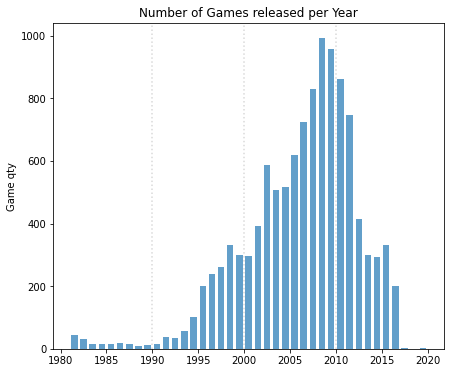

In [ ]:
plt.figure(figsize=(7,6))
plt.title('Number of Games released per Year')
plt.hist(df_f.drop_duplicates('Name')['Year'], bins=[a for a in range(1981,2021)],
         rwidth=0.7, alpha=0.7);
plt.ylabel('Game qty')
plt.axvline(x=1990, color='gray', alpha=0.3, linestyle=':')
plt.axvline(x=2000, color='gray', alpha=0.3, linestyle=':')
plt.axvline(x=2010, color='gray', alpha=0.3, linestyle=':')
plt.show()

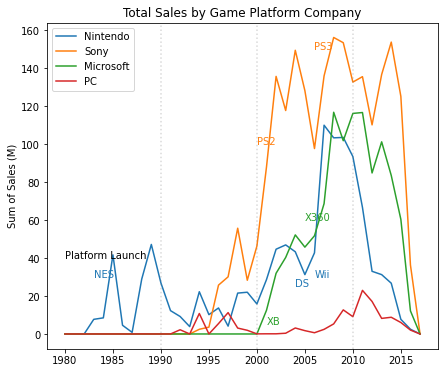

In [ ]:
# 그래프용 데이터 변환
com_sales2 = pd.pivot_table(df_duponly,index='Year', columns='Company', values='Sales_sum', aggfunc=np.sum).reset_index()
com_sales2.fillna(0, inplace=True)

# 연도별 회사별 게임 판매량 (선)
plt.figure(figsize=(7,6))
plt.plot(com_sales2['Year'],com_sales2[['Nintendo','Sony','Microsoft','PC']])
plt.title('Total Sales by Game Platform Company')
plt.legend(com_sales2[['Nintendo','Sony','Microsoft','PC']], loc='upper left')

plt.text(1983, 30, 'NES', color='C0')
plt.text(2004, 25, 'DS', color='C0')
plt.text(2006, 30, 'Wii', color='C0')

plt.text(2000, 100, 'PS2', color='C1')
plt.text(2006, 150, 'PS3', color='C1')

plt.text(2001, 5, 'XB', color='C2')
plt.text(2005, 60, 'X360', color='C2')

plt.text(1980, 40, 'Platform Launch', color='black')
plt.ylabel('Sum of Sales (M)')
plt.axvline(x=1990, color='gray', alpha=0.3, linestyle=':')
plt.axvline(x=2000, color='gray', alpha=0.3, linestyle=':')
plt.axvline(x=2010, color='gray', alpha=0.3, linestyle=':')


*   **1980년 ~ 1995년**

콘솔게임의 Platform 경쟁이 시작되기 전으로, 대부분 한 종류의 Platform을 지원하는 게임이 출시되었다.

*   **1995년 ~ 2000년초**

닌텐도가 강세인 시장에 소니가 참전하여 성공하면서 Platform 경쟁이 시작되었다. 기존에 출시된 게임들이 새로운 Platform으로 재출시되거나 처음부터 여러 Platform으로 출시되기 시작했다.

*   **2000년~**

닌텐도, 소니, MS의 Platform 경쟁이 심화되며 여러 Platform으로 출시되는 게임이 증가했다. 2010년 이후 PC게임이 성장하면서 PC게임으로 함께 출시되는 경우도 등장하였다. 

In [ ]:
top6 = df_f.groupby('Platform')['Sales_sum'].sum().sort_values(ascending=False)
top6 = pd.DataFrame(top6)
top6['ratio %'] = round((top6['Sales_sum'] / top6['Sales_sum'].sum()) *100, 2)
top6_table= top6.iloc[0:6]

print(top6_table)
print('-----------------------------')
print('               Total %' , round(top6_table['ratio %'].sum(),2))

          Sales_sum  ratio %
Platform                    
PS2         1222.44    13.95
X360         968.60    11.05
PS3          946.74    10.80
Wii          900.15    10.27
DS           817.24     9.33
PS           725.16     8.27
-----------------------------
               Total % 63.67


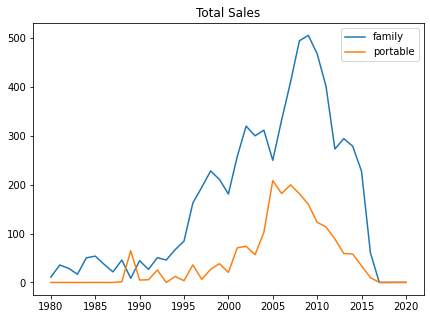

In [ ]:
game_tren = pd.pivot_table(df_f, index='Year', columns='Usage', values='Sales_sum', aggfunc=np.sum, margins=True).reset_index()
game_tren.fillna(0, inplace=True)
game_tren = game_tren[:-1]

# 연도별 가정용/휴대용 게임 판매량 (선)
plt.figure(figsize=(7,5))
plt.plot(game_tren['Year'],game_tren[['family','portable']])
plt.title('Total Sales')
plt.legend(game_tren[['family','portable']], loc='upper right')



*   대표적인 Platform 6개가 전체 매출의 64%를 차지한다.


*   휴대용 게임시장은 닌텐도**DS**, 소니의 **PSP**와 함께 성장하다가 스마트폰이 등장하면서 위축되었다. 스마트폰 게임이 게임성이나 조작편의 등에서 게임기에 비해 떨어질 수는 있으나 라이트 유저들에게는 별 문제가 되지 않는다. 또한 스마트폰 발전이 빠르게 적용되어 성능이 훨씬 나아졌기 때문으로 보인다.



#2) 연도별 게임 장르 트렌드


*    연도 구분: 1980년-1999년 / 2000년-2005년 / 2006년-2010년 / 2011년-2017년





*   시대별 주요특징


**1.   1980~1999년**

* **Platform** 장르의 매출이 두드러진다. 게임에 Platform(발판)이 등장하고, 점프를 하거나 캐릭터를 움직이며 진행하는 게임이다. 대표적으로 슈퍼마리오 게임이 있으며, 지금 만큼 게임기술이 발전하기 전으로 2D Platform 게임이 인기가 있었다. 하지만 매출에 비해 발매된 게임수는 적은편이었고, Sports 장르의 게임 발매가 많았다.
* **휴대용** 게임의 매출이 많이 성장했으나 게임 발매는 적었다. 대표적인 게임은 포켓몬, 테트리스가 있다. 


**2.   2000~2005년**

*   Action, Sports분야의 매출이 높고, 발매된 게임의 수도 많다.
*   특이한 점은 매출 TOP10 게임에 **Simulation** 장르가 처음 등장한 것이다.  동물의숲(Animal Crossing), 강아지키우기(Nintendogs)가 흥행했기 때문인데, Simulation 게임은 **장시간, 휴대용 게임기**로 플레이 했을때 더 효과적이므로, 닌텐도DS의 발매에 맞춰 좋은 컨텐츠가 출시된 것으로 보인다.    

**3.   2006~2010년**

* 총 매출과 발매된 게임 수도 가장 많은, **최고의 전성기** 시즌이었다.
* 2000년 초부터 흥행한 **소니의 플레이스테이션과 마이크로소프트의 XBOX가 경쟁하며 성장**했다. 또한 닌텐도DS의 전성기 였는데, 닌텐도 Wii가 새로 등장하며 신규 플레이 방식도 추가되었다. 


**4.   2011~2017년**

* 멀티플레이의 어려움, 높은 가격 등의 이유로 게임시장이 비디오게임에서 PC게임으로 트렌드가 급격히 변화하여 총 매출이 급속히 감소하였다.
* 그래픽 기술의 발달로 Action, Shooter의 대흥행작들이 등장했고, RPG게임도 발전하였다.

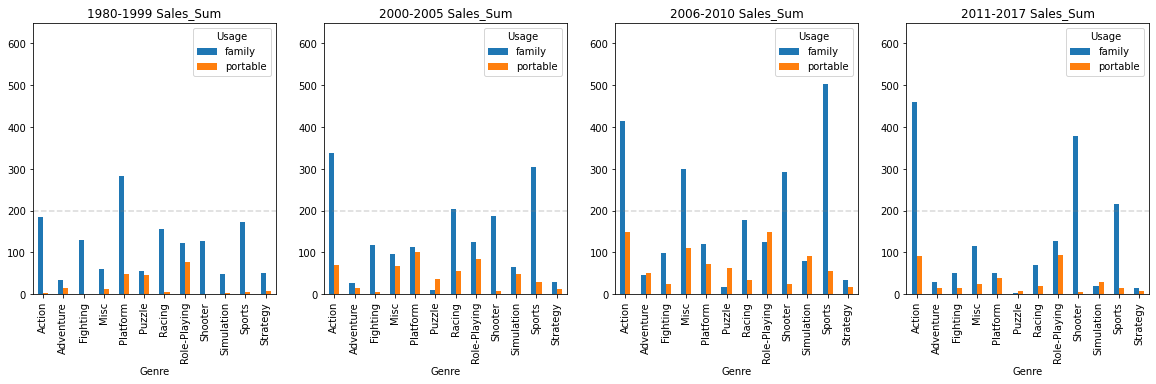

In [ ]:
# 매출
year_cond1 = (df_f['Year'] <= 1999)
year_cond2 = (df_f['Year'] >=2000) & (df_f['Year']<2006)
year_cond3 = (df_f['Year'] >=2006) & (df_f['Year']<2011)
year_cond4 = (df_f['Year'] >=2011) & (df_f['Year']<2017)

fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].set_title('1980-1999 Sales_Sum');
axes[1].set_title('2000-2005 Sales_Sum');
axes[2].set_title('2006-2010 Sales_Sum');
axes[3].set_title('2011-2017 Sales_Sum');

axes[0].axhline(200, color='gray', alpha=0.3, ls='--')
axes[1].axhline(200, color='gray', alpha=0.3, ls='--')
axes[2].axhline(200, color='gray', alpha=0.3, ls='--')
axes[3].axhline(200, color='gray', alpha=0.3, ls='--')

pd.pivot_table(df_f.loc[year_cond1], index='Genre', columns='Usage', values='Sales_sum', aggfunc='sum').plot.bar(ax=axes[0], figsize=(20,5), ylim=(0,650));
pd.pivot_table(df_f.loc[year_cond2], index='Genre', columns='Usage', values='Sales_sum', aggfunc='sum').plot.bar(ax=axes[1], figsize=(20,5), ylim=(0,650));
pd.pivot_table(df_f.loc[year_cond3], index='Genre', columns='Usage', values='Sales_sum', aggfunc='sum').plot.bar(ax=axes[2], figsize=(20,5), ylim=(0,650));
pd.pivot_table(df_f.loc[year_cond4], index='Genre', columns='Usage', values='Sales_sum', aggfunc='sum').plot.bar(ax=axes[3], figsize=(20,5), ylim=(0,650));

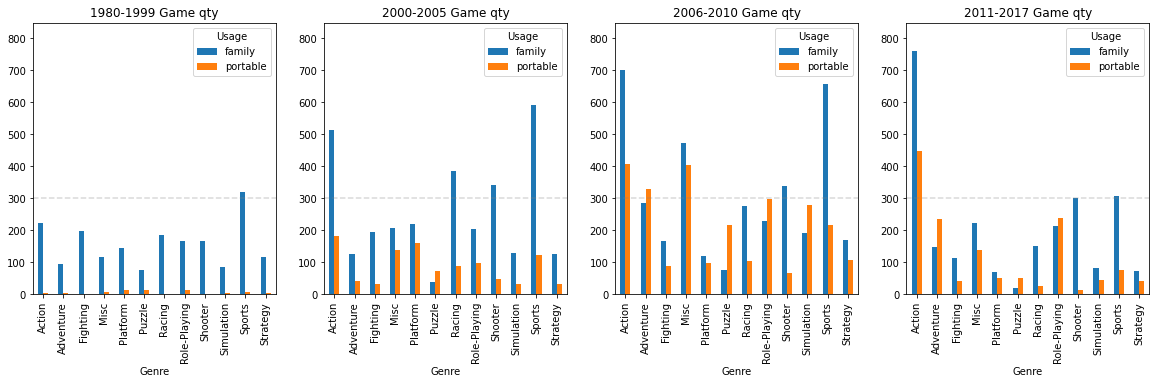

In [ ]:
# 출시 게임수
year_cond1 = (df_f['Year'] <= 1999)
year_cond2 = (df_f['Year'] >=2000) & (df_f['Year']<2006)
year_cond3 = (df_f['Year'] >=2006) & (df_f['Year']<2011)
year_cond4 = (df_f['Year'] >=2011) & (df_f['Year']<2017)

fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].set_title('1980-1999 Game qty');
axes[1].set_title('2000-2005 Game qty');
axes[2].set_title('2006-2010 Game qty');
axes[3].set_title('2011-2017 Game qty');

axes[0].axhline(300, color='gray', alpha=0.3, ls='--')
axes[1].axhline(300, color='gray', alpha=0.3, ls='--')
axes[2].axhline(300, color='gray', alpha=0.3, ls='--')
axes[3].axhline(300, color='gray', alpha=0.3, ls='--')

pd.pivot_table(df_f.loc[year_cond1], index='Genre', columns='Usage', values='Name', aggfunc='count').plot.bar(ax=axes[0], figsize=(20,5), ylim=(0,850));
pd.pivot_table(df_f.loc[year_cond2], index='Genre', columns='Usage', values='Name', aggfunc='count').plot.bar(ax=axes[1], figsize=(20,5), ylim=(0,850));
pd.pivot_table(df_f.loc[year_cond3], index='Genre', columns='Usage', values='Name', aggfunc='count').plot.bar(ax=axes[2], figsize=(20,5), ylim=(0,850));
pd.pivot_table(df_f.loc[year_cond4], index='Genre', columns='Usage', values='Name', aggfunc='count').plot.bar(ax=axes[3], figsize=(20,5), ylim=(0,850));

In [ ]:
# 연도별 매출 상위 게임 검색
df_f.loc[year_cond1].sort_values('Sales_sum', ascending=False).head(2)
df_f.loc[year_cond2].sort_values('Sales_sum', ascending=False).head(2)
df_f.loc[year_cond3].sort_values('Sales_sum', ascending=False).head(2)
df_f.loc[year_cond4].sort_values('Sales_sum', ascending=False).head(2)

# 플랫폼에 따른 검색
pla_cond = df_f['Platform']=='PC' 
df_f.loc[pla_cond].sort_values('Sales_sum', ascending=False).head(2)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_sum,Company,Usage
5438,The Sims 3,PC,2009,Simulation,Electronic Arts,0.98,6.42,0.0,0.71,8.11,PC,family
5916,World of Warcraft,PC,2004,Role-Playing,Activision,0.07,6.21,0.0,0.00,6.28,PC,family


## 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

1) 누적 매출 TOP10 게임현황

In [ ]:
# 1) 조건없이 총매출이 가장 높은 TOP 10 -- 파이차트
top10 = df_f.sort_values('Sales_sum', ascending=False)
top10 = top10.iloc[:10].reset_index(drop=True)
print(top10['Sales_sum'].sum()/df_f['Sales_sum'].sum())
# 전체 매출에서 비중 4.2% → 누적기준으로 한종류 게임이 오래, 많이 팔리는 것은 아님
# 비중이 높지 않지만 인기 게임의 특징 파악

# tidy data 만들기
region_list = ['NA_Sales','EU_Sales',	'JP_Sales',	'Other_Sales']
top10_tidy = pd.melt(top10, id_vars=['Name'], value_vars=region_list, var_name='Country', value_name='Sales')

0.04214995703874273


In [ ]:
df_1 = top10_tidy.groupby('Country')['Sales'].sum()
df_1 = pd.DataFrame(df_1).sort_values(by='Sales', ascending=False)
df_1 = df_1.rename(index={'Other_Sales':'Other', 'JP_Sales':'JP', 'EU_Sales':'EU', 'NA_Sales':'NA'})
df_2 = top10.groupby('Genre')['Sales_sum'].sum()
df_2 = pd.DataFrame(df_2).sort_values(by='Sales_sum', ascending=False)
df_3 = top10.groupby('Platform')['Sales_sum'].sum()
df_3 = pd.DataFrame(df_3).sort_values(by='Sales_sum', ascending=False)
df_4 = top10.groupby('Usage')['Sales_sum'].sum()
df_4 = pd.DataFrame(df_4).sort_values(by='Sales_sum', ascending=False)

Text(0.5, 1.0, 'Sales by Usage')

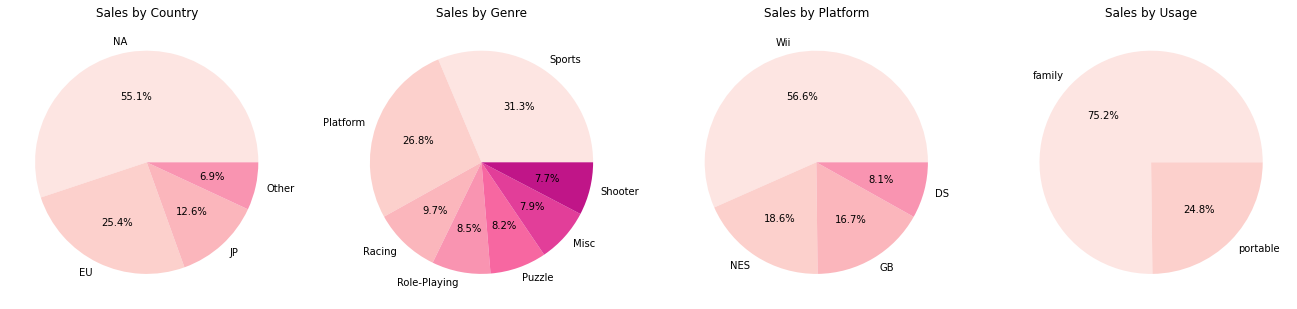

In [ ]:
colors = sns.color_palette('RdPu',9)

plt.figure(figsize=(23,7))

plt.subplot(141) 
plt.pie(df_1['Sales'], labels=df_1.index, autopct='%.1f%%', colors=colors)
plt.title('Sales by Country')
plt.subplot(142) 
plt.pie(df_2['Sales_sum'], labels=df_2.index, autopct='%.1f%%', colors=colors)
plt.title('Sales by Genre')
plt.subplot(143) 
plt.pie(df_3['Sales_sum'], labels=df_3.index, autopct='%.1f%%', colors=colors)
plt.title('Sales by Platform')
plt.subplot(144) 
plt.pie(df_4['Sales_sum'], labels=df_4.index, autopct='%.1f%%', colors=colors)
plt.title('Sales by Usage')

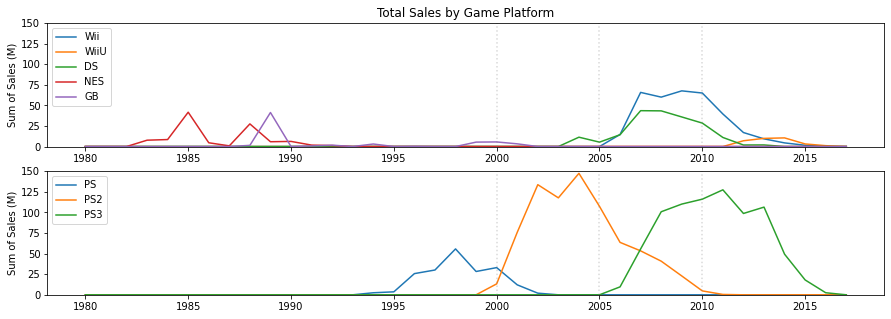

In [ ]:
# 그래프용 데이터 변환
com_sales3 = pd.pivot_table(df_duponly,index='Year', columns='Platform', values='Sales_sum', aggfunc=np.sum).reset_index()
com_sales3.fillna(0, inplace=True)

plt.figure(figsize=(15,5))
# 연도별 회사별 게임 판매량 (선)
plt.subplot(211) 
plt.plot(com_sales3['Year'],com_sales3[['Wii','WiiU', 'DS', 'NES', 'GB']])
plt.title('Total Sales by Game Platform')
plt.legend(com_sales3[['Wii','WiiU', 'DS', 'NES', 'GB']], loc='upper left')
plt.ylabel('Sum of Sales (M)')
plt.ylim(0,150)
plt.axvline(x=2000, color='gray', alpha=0.3, linestyle=':')
plt.axvline(x=2005, color='gray', alpha=0.3, linestyle=':')
plt.axvline(x=2010, color='gray', alpha=0.3, linestyle=':')

# 연도별 회사별 게임 판매량 (선)
plt.subplot(212) 
plt.plot(com_sales3['Year'],com_sales3[['PS','PS2','PS3']])
plt.legend(com_sales3[['PS','PS2','PS3']], loc='upper left')
plt.ylabel('Sum of Sales (M)')
plt.ylim(0,150)
plt.axvline(x=2000, color='gray', alpha=0.3, linestyle=':')
plt.axvline(x=2005, color='gray', alpha=0.3, linestyle=':')
plt.axvline(x=2010, color='gray', alpha=0.3, linestyle=':')



*   매출량이 많은 게임 TOP10이 전체 매출에서 비중 4.2%이며, 전부 **닌텐도**의 게임이다. 
*   판매 1위인 **'Wii Sports'**가 2위 'Super Mario Bros.' 매출의 2배를 넘는 높은 기록을 세웠다.
*   TOP10의 지역별 매출 역시 전체Trend와 동일하게 북미 > 유럽 > 일본 > 기타 순으로 매출이 많다.
*   매출1위와 4위를 한 Wii Sports 시리즈의 영향으로, 가장 인기있는 장르가 Sports가 되었다.
*   특히 TOP10의 절반이 **Wii**의 게임으로, Wii Platform(family용)이 가장 우세한 것으로 나왔다.
*   하지만 크게 성공했던 Wii가 **2009년 기점으로 정체**되어 10년부터 하락하기 시작했으며, 후속작 WiiU도 결국 실패했다. 판매량으로 성공했었지만 오래 지속되지 못했다. 콘솔시장 Platform에서 영향력은 소니의 **PS**시리즈가 매우 강력하다. 





2) 최근 5개년 데이터 (~17년)

In [ ]:
con_year = (df_f['Year'] >= 2013) &(df_f['Year'] <2020)
latest_year = df_f[con_year]
latest_yearsum = latest_year.replace({'Puzzle':'etc', 'Strategy':'etc', 'PSP':'etc', 'DS':'etc'})

In [ ]:
region_list = ['NA_Sales','EU_Sales',	'JP_Sales',	'Other_Sales']
latest_tidy = pd.melt(latest_year, id_vars=['Name'], value_vars=region_list, var_name='Country', value_name='Sales')
df_11 = latest_tidy.groupby('Country')['Sales'].sum()
df_11 = pd.DataFrame(df_11).sort_values(by='Sales', ascending=False)
df_11 = df_11.rename(index={'Other_Sales':'Other', 'JP_Sales':'JP', 'EU_Sales':'EU', 'NA_Sales':'NA'})

df_12 = latest_yearsum.groupby('Genre')['Sales_sum'].sum()
df_12 = pd.DataFrame(df_12).sort_values(by='Sales_sum', ascending=False)

df_13 = latest_yearsum.groupby('Platform')['Sales_sum'].sum()
df_13 = pd.DataFrame(df_13).sort_values(by='Sales_sum', ascending=False)

df_14 = latest_year.groupby('Usage')['Sales_sum'].sum()
df_14 = pd.DataFrame(df_14).sort_values(by='Sales_sum', ascending=False)

Text(0.5, 1.0, 'Sales by Usage')

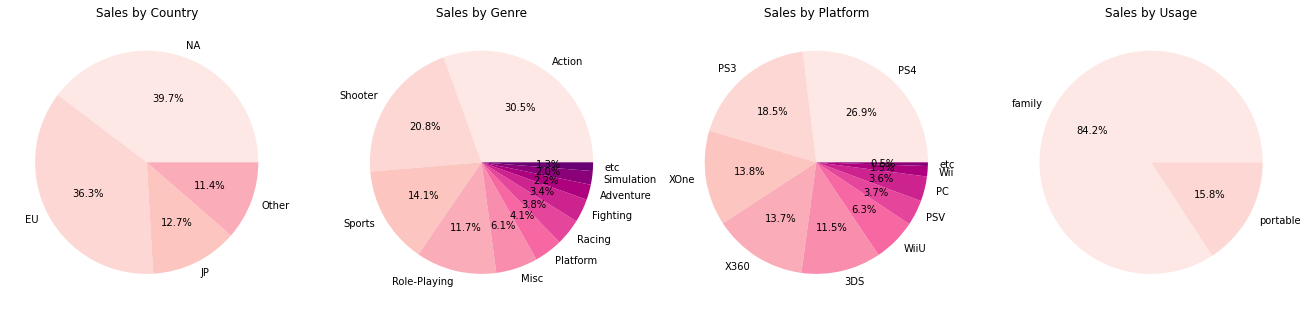

In [ ]:
colors = sns.color_palette('RdPu',11)
plt.figure(figsize=(23,7))

plt.subplot(141) 
plt.pie(df_11['Sales'], labels=df_11.index, autopct='%.1f%%', colors=colors)
plt.title('Sales by Country')
plt.subplot(142) 
plt.pie(df_12['Sales_sum'], labels=df_12.index, autopct='%.1f%%', colors=colors)
plt.title('Sales by Genre')
plt.subplot(143) 
plt.pie(df_13['Sales_sum'], labels=df_13.index, autopct='%.1f%%', colors=colors)
plt.title('Sales by Platform')
plt.subplot(144) 
plt.pie(df_14['Sales_sum'], labels=df_14.index, autopct='%.1f%%', colors=colors)
plt.title('Sales by Usage')

*   최근 5개년도 지역별 매출 Trend는 유지가 되어 북미 > 유럽 > 일본 > 기타 순으로 매출이 많다.
*   장르는 지속적으로 강세였던 **Action, Shooter, Sports**가 여전히 매출 상위권 이다.
*   Platform에서는 소니의 **PS** 시리즈가 상위권을 차지하며, 여전히 MS **XBOX**, 닌텐도와 경쟁하고 있다. 
*   북미,유럽 매출이 높으므로 그 영향을 받아 여전히 콘솔(family)이 비중이 높다.
*   모바일 게임의 득세이후 휴대용 게임시장은 파이가 상당히 줄었고, 2017년 닌텐도 스위치 출시 이후로는 사실상 단독 휴대용 게임기 콘솔시장이 사라졌다고 할 수 있다.


3-1) 다중 플랫폼으로 출시된 게임 현황



*    PS와 XBOX가 콘솔시장의 큰 비중을 차지하고 있다.
*   콘솔과 PC가 시스템 구조적으로 유사하게 발전하면서, 여태까지 다른 경향을 띠던 콘솔과 PC게임의 경계가 허물어지며 콘솔에 출시되던 게임들이 PC에도 같이 출시되는 경우가 증가했다. 
*   전체 매출중 **52%**가 **같은 게임이 여러 플랫폼으로 출시**되었다.
*   당연히 다양한 버전으로 발매하면 총 매출은 증가한다. 하지만 발매종류가 계속 많아져도, 모든 버전이 판매에 성공하는 것은 아니므로 평균 매출이 감소할 수 있어 항상 양의 상관관계가 있는 것은 아니다. (통계적 검증)






In [ ]:
df_duponly['Sales_sum'].sum() / df_f['Sales_sum'].sum()

0.5234130294133421

In [ ]:
# 매출 합계
sales_g = df_duponly.groupby('Name')['Sales_sum'].sum().sort_values(ascending=False)
sales_g = pd.DataFrame(sales_g)

# 출시된 platform 수
df_dupcon = df_duponly['Name'].value_counts()
df_dupcon = pd.DataFrame(df_dupcon)

last = sales_g.join(df_dupcon) 
last = last.rename(columns={'Name':'Type'})
last['Average'] = last['Sales_sum']/last['Type']

In [ ]:
# sales_sum 상위 5개 게임
last.sort_values(by='Sales_sum', ascending=False).iloc[:5]

,Sales_sum,Type,Average
Name,,,
Grand Theft Auto V,55.92,5,11.1840
Super Mario Bros.,45.31,2,22.6550
Tetris,35.84,2,17.9200
Call of Duty: Modern Warfare 3,30.84,4,7.7100
Call of Duty: Black Ops II,29.73,4,7.4325


In [ ]:
# 발매 수량 반영한 average_sales 상위 5개
last.sort_values(by='Average', ascending=False).iloc[:5]

,Sales_sum,Type,Average
Name,,,
Super Mario Bros.,45.31,2,22.655
Tetris,35.84,2,17.920
Super Mario World,26.09,2,13.045
Super Mario Bros. 3,22.49,2,11.245
Grand Theft Auto V,55.92,5,11.184


In [ ]:
# 출시된 플랫폼이 많으면 매출이 증가하는가 (상관관계 분석)
# 상관계수가 0.35로 양적 선형관계가 성립한다고 볼 수 있다.
np.corrcoef(last['Sales_sum'],last['Type'])

array([[1.        , 0.34637153],
       [0.34637153, 1.        ]])

In [ ]:
# 상관관계 검정
# 귀무가설: 상관관계가 없다
# pvalue <0.05 이므로 귀무가설을 기각, 상관관계가 있다.
stats.pearsonr(last['Sales_sum'],last['Type'])

(0.34637152664909454, 2.732910137510186e-77)

In [ ]:
# 상관계수가 0.89로 강한 양적 선형관계가 성립한다고 볼 수 있다.
np.corrcoef(last['Sales_sum'],last['Average'])

array([[1.        , 0.89242528],
       [0.89242528, 1.        ]])

In [ ]:
# 상관계수가 0.07로 상관관계가 성립하지 않는다.
np.corrcoef(last['Type'],last['Average'])

array([[1.       , 0.0756721],
       [0.0756721, 1.       ]])

3-2) 플랫폼과 장르의 연관성
*   장르에 따라 출시되는 플랫폼이 연관이 있는가

In [ ]:
plat_gen = pd.pivot_table(latest_year, index='Genre', columns='Platform', values='Sales_sum', aggfunc=np.sum)
plat_gen = plat_gen.fillna(0)
plat_gen

Platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
Genre,,,,,,,,,,,
Action,32.83,0.67,6.91,73.78,84.70,0.87,11.61,3.22,14.90,49.06,33.78
Adventure,3.24,0.03,0.47,4.53,4.70,0.71,3.77,0.27,0.19,2.12,2.49
Fighting,8.08,0.00,0.10,6.16,8.04,0.02,1.47,0.00,6.16,2.64,2.34
Misc,6.56,0.08,0.70,8.57,7.37,0.17,4.56,7.71,7.07,12.53,6.88
Platform,8.61,0.92,0.06,3.52,6.99,0.00,0.62,2.45,16.03,2.09,0.80
Puzzle,1.74,0.00,0.00,0.04,0.02,0.00,0.06,0.00,1.34,0.00,0.00
Racing,0.00,0.00,0.94,7.32,11.57,0.00,0.10,0.00,7.24,3.32,8.83
Role-Playing,44.61,0.00,4.71,17.08,25.78,1.03,10.87,0.00,1.46,4.65,9.46
Shooter,0.06,0.00,9.10,33.37,75.32,0.00,1.84,0.00,5.61,36.12,51.59


In [ ]:
df_15 = pd.DataFrame(plat_gen.iloc[0]).sort_values(by='Action', ascending=False) # action
df_15 = df_15.iloc[:-3]
df_16 = pd.DataFrame(plat_gen.iloc[8]).sort_values(by='Shooter', ascending=False) # shooter
df_16 = df_16.iloc[:-4]               
df_17 = pd.DataFrame(plat_gen.iloc[10]).sort_values(by='Sports', ascending=False) # sports
df_17 = df_17.iloc[:-4]
df_18 = pd.DataFrame(plat_gen.iloc[7]).sort_values(by='Role-Playing', ascending=False) # role-playing
df_18 = df_18.iloc[:-4]

Text(0.5, 1.0, 'Role-Playing')

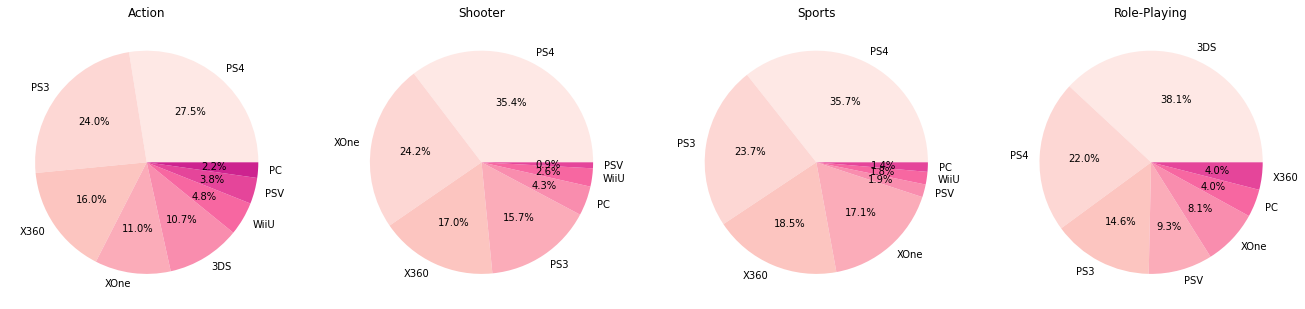

In [ ]:
colors = sns.color_palette('RdPu',11)
plt.figure(figsize=(23,7))

plt.subplot(141) 
plt.pie(df_15['Action'], labels=df_15.index, autopct='%.1f%%', colors=colors)
plt.title('Action')

plt.subplot(142) 
plt.pie(df_16['Shooter'], labels=df_16.index, autopct='%.1f%%', colors=colors)
plt.title('Shooter')

plt.subplot(143) 
plt.pie(df_17['Sports'], labels=df_17.index, autopct='%.1f%%', colors=colors)
plt.title('Sports')

plt.subplot(144) 
plt.pie(df_18['Role-Playing'], labels=df_18.index, autopct='%.1f%%', colors=colors)
plt.title('Role-Playing')



*   매출 상위권 장르를 살펴보면 Platform에서 **PS**와 **XBOX**가 절대적인 비중을 차지한다. 2가지 Platform만으로 50%에 가까운 비중을 달성할 수 있다. 
*   Role-Playing은 **3DS**가 가장 점유율이 높지만, **PS**시리즈는 여전히 인기가 많다.



## 게임 개발 전략방향

단기 전략
*   주력시장**(북미, 유럽)**에서 인기있는 Platform 특화된 게임을 출시한다.
*   대표적 플랫폼인 **PS, XBOX** 두가지로 출시하는 것이 주요하며, 가장 인기있는 장르  **Action, Shooter** 중에서 자사가 기술적 강점을 가진 장르로 선정한다.


장기 전략

*   현재 게임시장이 PC 및 모바일이 큰 비중을 차지하게 변화하였다. 콘솔게임과 PC게임의 경계도 사라지는 추세이며, 연결된 동일한 온라인 서버를 공유하며 플랫폼 및 기기간 교류가 가능한 게임들에 대한 고객 니즈가 많아지고 있다. 각각의 특징을 간략히 살펴보면,
*   1) **모바일 게임**: 게임을 할 수 있는 시간적 제약이 적다. 하지만 하드웨어 한계로 구현가능한 게임이 한정적이고, 일부 게임플레이에 적합도가 낮다.
*   2) **PC,콘솔게임**: 기기 성능이 더 좋지만 휴대성이 떨어진다. 

* **크로스 플랫폼 지원하는 방향으로 개발 필요** : 콘솔 + 모바일 + PC, 최소2가지 지원, 다양한 기기에서 동일한 게임 지원
*   필요에 따라 플랫폼을 바꿔가며 플레이 할 수 있게 되면 **게임시간을 증가**시킬 수 있다. 또한 **플레이어의 커뮤니티를 확장**할 수 있는데 서로 다른 플랫폼을 선호하는 사람들을 만나 함께 플레이 할 수 있는 환경이 조성되므로 게임 선호도가 상승할 수 있다. 다만 개발의 복잡도가 증가하므로, 개발 시간이 증가할 수 있다. 장기적 방향성으로 잡고 진행할 필요가 있다. 





